# **Entrenamiento con datagen y fine-tuning**

Emplearemos los mismos modelos que en el caso de modelos simples, con la diferencia de que esta vez emplearemos la tecnica de datagen para aumentar la cantidad de datos de los que podemos disponer a la hora de entrenar. Además, aplicaremos la tecnica de fine-tuning sobre los modelos, consistente en descongelar sus ultimas capas para que los pesos puedan reajustarse.

## **Importar dataset**

In [1]:
import kagglehub    # Libreria para la descarga de archivos de kaggle.

# Download latest version.
path = kagglehub.dataset_download("gpiosenka/railway-track-fault-detection-resized-224-x-224")

print("Path to dataset files:", path)

100%|██████████| 12.7M/12.7M [00:00<00:00, 14.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/railway-track-fault-detection-resized-224-x-224/versions/2


## **Directorios**

In [2]:
# Necesitaremos la librería os, que nos permite interactuar con el sistema operativo y manipular rutas.
import os

# Directorio de entrenamiento:
train_dir = os.path.join(path, 'train')
# Directorio de pruebas:
test_dir = os.path.join(path, 'test')
# Directorio de validacion:
valid_dir = os.path.join(path, 'valid')

## **Importar modelos**

In [3]:
# Los modelos pre-entrenados se encontrarán en la librería de tensorflow.
import tensorflow as tf

# Aprovechamos para fijar la semilla y evitar la aleatoriedad entre simulaciones.
import os
import random
import numpy as np

# Fijar semillas
Semilla = 42
os.environ['PYTHONHASHSEED'] = str(Semilla) # Controlamos la aleatoridad en el hashing de objetos.
random.seed(Semilla)                        # Controlamos la aleatoridad en la generación de números aleatorios.
np.random.seed(Semilla)                     # Controlamos la aleatoridad en la generación de números aleatorios en numpy.
tf.random.set_seed(Semilla)                 # Controlamos la aleatoridad en la generación de números aleatorios en tensorflow.

# Configurar comportamiento determinista en TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'    # Configuramos una variable de entorno destinada a ciertas operaciones no deterministas como deterministas.

### VGG16

In [4]:
VGG16_Base = (tf.keras.applications.VGG16(include_top=False,          # Eliminamos su clasificador.
                                          weights='imagenet',         # Mantenemos los pesos de cada capa.
                                          input_shape=(224, 224, 3))) # Especificamos el tamaño de los datos de entrada.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
# Congelamos el modelo.
for layer in VGG16_Base.layers:
  layer.trainable = False

In [6]:
# Visualizamos el modelo completo.
VGG16_Base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### VGG19

In [7]:
VGG19_Base = (tf.keras.applications.VGG19(include_top=False,
                                          weights='imagenet',
                                          input_shape=(224, 224, 3)))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
# Congelamos el modelo.
for layer in VGG19_Base.layers:
  layer.trainable = False

In [9]:
# Visualizamos el modelo completo.
VGG19_Base.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

### NasNetLarge

In [10]:
NasNetLarge_Base = (tf.keras.applications.NASNetLarge(include_top=False,
                                                      weights='imagenet',
                                                      input_shape=(224, 224, 3)))

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [11]:
# Congelamos el modelo.
for layer in NasNetLarge_Base.layers:
  layer.trainable = False

In [12]:
# Visualizamos el modelo completo.
NasNetLarge_Base.summary()

Model: "nasnet_large"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │      2,592 │ input_layer_2[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        384 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │      4,032 │ activation[0][0]  │
│ (Conv2D)            │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │        168 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      2,814 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      8,736 │ separable_conv_1… │
│ (SeparableConv2D)   │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │        168 │ separable_conv_1… │
│ (BatchNormalizatio… │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 42)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │      2,814 │ activation_2[0][

 Total params: 84,916,818 (323.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 84,916,818 (323.93 MB)

### InceptionResNetV2

In [13]:
InceptionResNetV2_Base = (tf.keras.applications.InceptionResNetV2(include_top=False,
                                                                  weights='imagenet',
                                                                  input_shape=(224, 224, 3)))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [14]:
# Congelamos el modelo.
for layer in InceptionResNetV2_Base.layers:
  layer.trainable = False

In [15]:
# Visualizamos el modelo completo.
InceptionResNetV2_Base.summary()

Model: "inception_resnet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_260      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation_260[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_261      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_261[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_262      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_262[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_263      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_263[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_264      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 54,336,736 (207.28 MB)

### ResNet50

In [16]:
ResNet50_Base = (tf.keras.applications.ResNet50(include_top=False,
                                                weights='imagenet',
                                                input_shape=(224, 224, 3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
# Congelamos el modelo.
for layer in ResNet50_Base.layers:
  layer.trainable = False

In [18]:
# Visualizamos el modelo completo.
ResNet50_Base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

### Xception

In [19]:
Xception_Base = (tf.keras.applications.Xception(include_top=False,
                                                weights='imagenet',
                                                input_shape=(224, 224, 3)))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [20]:
# Congelamos el modelo.
for layer in Xception_Base.layers:
  layer.trainable = False

In [21]:
# Visualizamos el modelo completo.
Xception_Base.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_5[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_203[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_4[0][0]     

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

## **Entrenamiento**

La cantidad de datos con los que trabajamos es bastante baja, lo que provoca que nuestro se adapte demasiado bien a los datos de entrada, generando el efecto de overfitting. Para ayudar a reducirlo disponemos de diferentes metodos. En este documento aplicaremos la generacion de imagenes, basada en un algoritmo que realiza transformaciones sobre los datos de entrada, aumentando asi la cantidad de elementos "nuevos" de los que disponemos.

### Datos de entrada

In [22]:
# Importamos la clase ImageDataGenerator contenido en Keras.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
# Definimos las operaciones que se realizarán para data augmentation.
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalizamos los datos.
    shear_range=0.2,            # Ángulo de corte máximo de 2º.
    zoom_range=0.3,             # Zoom de hasta un 30%.
    horizontal_flip=True,       # Flip en el eje horizontal.
    vertical_flip=True,         # Flip en el eje vertical.
    width_shift_range=0.3,      # Desplazamiento horizontal de hasta 30%.
    height_shift_range=0.2,     # Desplazamiento vertical de hasta 20%.
    brightness_range=[0.4,1.5]) # Ajuste del brillo en la imagen.

# Es importante que los generadores de validación y de prueba solo reciban reescalado.
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
# Definimos los generadores para cada uno de los conjuntos.
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    subset='training'          # Nombre del subset originado.
)
validation_generator = validation_datagen.flow_from_directory(
    valid_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)
test_generator = test_datagen.flow_from_directory(
    test_dir,                  # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


### Modelo VGG16

In [25]:
# Creamos un modelo nuevo.
VGG16_dg = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_dg.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_dg.add(tf.keras.layers.Flatten())
VGG16_dg.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_dg.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_dg.add(tf.keras.layers.Dropout(0.3))
VGG16_dg.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_dg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Modelo VGG19

In [26]:
# Creamos un modelo nuevo.
VGG19_dg = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG19_dg.add(VGG19_Base)

# Añadimos el clasificador categórico.
VGG19_dg.add(tf.keras.layers.Flatten())
VGG19_dg.add(tf.keras.layers.Dense(500, activation='relu'))
VGG19_dg.add(tf.keras.layers.Dense(200, activation='relu'))
VGG19_dg.add(tf.keras.layers.Dropout(0.3))
VGG19_dg.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG19_dg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,669,486 (124.62 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

### Modelo NASNetLarge

In [27]:
# Creamos un modelo nuevo.
NasNetLarge_dg = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
NasNetLarge_dg.add(NasNetLarge_Base)

# Añadimos el clasificador categórico.
NasNetLarge_dg.add(tf.keras.layers.Flatten())
NasNetLarge_dg.add(tf.keras.layers.Dense(500, activation='relu'))
NasNetLarge_dg.add(tf.keras.layers.Dense(200, activation='relu'))
NasNetLarge_dg.add(tf.keras.layers.Dropout(0.3))
NasNetLarge_dg.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
NasNetLarge_dg.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_large (Functional)       │ (None, 7, 7, 4032)     │    84,916,818 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 197568)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 500)            │    98,784,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,801,920 (701.15 MB)

 Trainable params: 98,885,102 (377.22 MB)

 Non-trainable params: 84,916,818 (323.93 MB)

### Modelo InceptionResNetV2

In [28]:
# Creamos un modelo nuevo.
InceptionResNetV2_dg = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
InceptionResNetV2_dg.add(InceptionResNetV2_Base)

# Añadimos el clasificador categórico.
InceptionResNetV2_dg.add(tf.keras.layers.Flatten())
InceptionResNetV2_dg.add(tf.keras.layers.Dense(500, activation='relu'))
InceptionResNetV2_dg.add(tf.keras.layers.Dense(200, activation='relu'))
InceptionResNetV2_dg.add(tf.keras.layers.Dropout(0.3))
InceptionResNetV2_dg.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
InceptionResNetV2_dg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 500)            │    19,200,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,637,838 (280.91 MB)

 Trainable params: 19,301,102 (73.63 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

### Modelo ResNet50

In [29]:
# Creamos un modelo nuevo.
ResNet50_dg = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
ResNet50_dg.add(ResNet50_Base)

# Añadimos el clasificador categórico.
ResNet50_dg.add(tf.keras.layers.Flatten())
ResNet50_dg.add(tf.keras.layers.Dense(500, activation='relu'))
ResNet50_dg.add(tf.keras.layers.Dense(200, activation='relu'))
ResNet50_dg.add(tf.keras.layers.Dropout(0.3))
ResNet50_dg.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
ResNet50_dg.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 500)            │    50,176,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,864,814 (281.77 MB)

 Trainable params: 50,277,102 (191.79 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Modelo Xception

In [30]:
# Creamos un modelo nuevo.
Xception_dg = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
Xception_dg.add(Xception_Base)

# Añadimos el clasificador categórico
Xception_dg.add(tf.keras.layers.Flatten())
Xception_dg.add(tf.keras.layers.Dense(500, activation='relu'))
Xception_dg.add(tf.keras.layers.Dense(200, activation='relu'))
Xception_dg.add(tf.keras.layers.Dropout(0.3))
Xception_dg.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
Xception_dg.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 500)            │    50,176,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,138,582 (271.37 MB)

 Trainable params: 50,277,102 (191.79 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

### Simulación

In [31]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,  Callback # Son algoritmos que ayudan a evitar que nuestro modelo entre en overfitting
import time

# Definimos tanto la reducción de learning rate como la parada prematura.
# La reducción de learning rate se encargará de determinar como de rápido debe aprender nuestro modelo.
rlr = ReduceLROnPlateau(monitor = 'val_loss', # Variable a monitorear.
                        factor = 0.1,         # Cuanto debe reducirse el lr. new_lr = lr*factor.
                        patience = 4,         # Número de épocas sin mejoras para que se reduzca el lr.
                        verbose = 1,          # Información de estado.
                        min_delta = 1e-5,     # Margen sobre el que se determina el nuevo óptimo.
                        min_lr = 1e-5,        # Learning rate minimo a alcanzar.
                        mode = 'min',         # Modo de actuación.
                        cooldown=1)           # Numero de epocas necesarias para volver a trabajar normalmente.

# Early stop moniteará la perdida de validacion, terminando el entrenamiento cuando se detecte que se acerca al overfitting.
early_stop = EarlyStopping(monitor = 'val_loss',        # Variable a monitorear.
                           min_delta = 1e-5,            # Mínimo cambio en la variable a monitorear para tomarlo como una mejora.
                           patience = 8,                # Número de épocas sin mejoras a partir de la cual se parará la simulación.
                           mode = 'min',                # Modo de trabajo.
                           restore_best_weights = True, # Restablece los pesos de la época en la que la variable monitoreada fue mejor.
                           verbose = 1)                 # Información de estado.

# Creamos la lista de callbacks.
callbacks_list = [early_stop, rlr]

#### VGG16

In [32]:
# Compilamos el modelo antes definido.
VGG16_dg.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_start_time = time.time()
VGG16_dg_history = VGG16_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 648ms/step - acc: 0.5435 - loss: 2.7323 - val_acc: 0.5000 - val_loss: 0.7686 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 643ms/step - acc: 0.5640 - loss: 1.8452 - val_acc: 0.7258 - val_loss: 0.5137 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 632ms/step - acc: 0.5550 - loss: 1.0386 - val_acc: 0.5968 - val_loss: 0.6459 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 658ms/step - acc: 0.5177 - loss: 0.8283 - val_acc: 0.6935 - val_loss: 0.5063 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 709ms/step - acc: 0.6464 - loss: 0.6663 - val_acc: 0.7742 - val_loss: 0.4738 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 548ms/step - acc: 0.6883 - loss: 0.6135 - val_acc: 0.7581 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 645ms/step - acc: 0.7007 - loss: 0.5803 - val_acc: 0.7097 - val_loss: 0.5388 - learning_rate: 0.00

In [33]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_dg.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_dg_history = VGG16_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)
VGG16_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_end_time - VGG16_start_time} segundos")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 721ms/step - acc: 0.6087 - loss: 1.2644 - val_acc: 0.7258 - val_loss: 0.5680 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 702ms/step - acc: 0.6559 - loss: 0.6007 - val_acc: 0.7742 - val_loss: 0.4816 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 638ms/step - acc: 0.6204 - loss: 0.6654 - val_acc: 0.7581 - val_loss: 0.4901 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 565ms/step - acc: 0.7102 - loss: 0.5521 - val_acc: 0.7419 - val_loss: 0.5135 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 651ms/step - acc: 0.7681 - loss: 0.4792 - val_acc: 0.7742 - val_loss: 0.7247 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 599ms/step - acc: 0.7623 - loss: 0.5152 - val_acc: 0.7903 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - acc: 0.7674 - loss: 0.4843 - val_acc: 0.7903 - val_loss: 0.5199 - learning_rate: 0.

In [34]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_dg_acc = VGG16_dg_history.history['acc']
VGG16_dg_val_acc = VGG16_dg_history.history['val_acc']
VGG16_dg_loss = VGG16_dg_history.history['loss']
VGG16_dg_val_loss = VGG16_dg_history.history['val_loss']

#### VGG19

In [35]:
# Compilamos el modelo antes definido.
VGG19_dg.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG19_start_time = time.time()
VGG19_dg_history = VGG19_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 807ms/step - acc: 0.4696 - loss: 2.8301 - val_acc: 0.5000 - val_loss: 1.9095 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 622ms/step - acc: 0.4988 - loss: 2.1027 - val_acc: 0.5000 - val_loss: 1.3083 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step - acc: 0.5569 - loss: 1.2838 - val_acc: 0.5161 - val_loss: 0.8234 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 629ms/step - acc: 0.5522 - loss: 1.0154 - val_acc: 0.7419 - val_loss: 0.5342 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 618ms/step - acc: 0.5931 - loss: 0.7921 - val_acc: 0.7742 - val_loss: 0.5140 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 600ms/step - acc: 0.6187 - loss: 0.7170 - val_acc: 0.7903 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 652ms/step - acc: 0.5751 - loss: 0.7359 - val_acc: 0.7581 - val_loss: 0.4732 - learning_rate: 0.

In [36]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG19_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo.
VGG19_dg.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG19_dg_history = VGG19_dg.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks_list)
VGG19_end_time = time.time()
print(f"Tiempo de ejecución: {VGG19_end_time - VGG19_start_time} segundos")

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 775ms/step - acc: 0.6501 - loss: 2.6281 - val_acc: 0.6774 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 722ms/step - acc: 0.5979 - loss: 0.6682 - val_acc: 0.7097 - val_loss: 0.5389 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 692ms/step - acc: 0.6541 - loss: 0.6040 - val_acc: 0.7581 - val_loss: 0.5162 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 626ms/step - acc: 0.6716 - loss: 0.6029 - val_acc: 0.7742 - val_loss: 0.4757 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 696ms/step - acc: 0.7312 - loss: 0.5162 - val_acc: 0.7903 - val_loss: 0.5409 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 609ms/step - acc: 0.7339 - loss: 0.5349 - val_acc: 0.7742 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 703ms/step - acc: 0.7626 - loss: 0.4493 - val_acc: 0.7581 - val_loss: 0.4721 - learning_rate: 0.0010
Epoc

In [37]:
# Obtenemos los parametros de interes de la simulacion.
VGG19_dg_acc = VGG19_dg_history.history['acc']
VGG19_dg_val_acc = VGG19_dg_history.history['val_acc']
VGG19_dg_loss = VGG19_dg_history.history['loss']
VGG19_dg_val_loss = VGG19_dg_history.history['val_loss']

#### NASNetLarge

In [38]:
# Compilamos el modelo antes definido.
NasNetLarge_dg.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(),
                      metrics=['acc'])

# Realizamos el entrenamiento.
NasNetLarge_start_time = time.time()
NasNetLarge_dg_history = NasNetLarge_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - acc: 0.5048 - loss: 17.9934 - val_acc: 0.5000 - val_loss: 20.0484 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - acc: 0.5735 - loss: 12.3544 - val_acc: 0.5000 - val_loss: 16.0317 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - acc: 0.5547 - loss: 7.7656 - val_acc: 0.6774 - val_loss: 2.3235 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - acc: 0.6431 - loss: 2.9246 - val_acc: 0.6613 - val_loss: 1.3359 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.6770 - loss: 2.3717 - val_acc: 0.6935 - val_loss: 1.1223 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 999ms/step - acc: 0.6211 - loss: 1.7818 - val_acc: 0.6452 - val_loss: 1.6222 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.7081 - loss: 0.8611 - val_acc: 0.6290 - val_loss: 1.3456 - learning_rate: 0.0010
Epoch 

In [39]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in NasNetLarge_Base.layers[-3:]:
    layer.trainable = True

# Compilamos nuevamente el modelo.
NasNetLarge_dg.compile(loss='categorical_crossentropy',
                      optimizer=optimizers.Adam(),
                      metrics=['acc'])

# Realizamos el entrenamiento.
NasNetLarge_dg_history = NasNetLarge_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)
NasNetLarge_end_time = time.time()
print(f"Tiempo de ejecución: {NasNetLarge_end_time - NasNetLarge_start_time} segundos")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - acc: 0.7311 - loss: 0.6612 - val_acc: 0.7419 - val_loss: 0.5236 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - acc: 0.7613 - loss: 0.5967 - val_acc: 0.7419 - val_loss: 1.3708 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.7313 - loss: 0.6810 - val_acc: 0.7742 - val_loss: 0.5189 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.7359 - loss: 0.5439 - val_acc: 0.6935 - val_loss: 0.4862 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 929ms/step - acc: 0.7028 - loss: 0.5304 - val_acc: 0.6935 - val_loss: 0.5304 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.7254 - loss: 0.4882 - val_acc: 0.7903 - val_loss: 0.4304 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 996ms/step - acc: 0.7242 - loss: 0.5702 - val_acc: 0.7258 - val_loss: 0.4415 - learning_rate: 0.0010
Epoch 8

In [40]:
# Obtenemos los parametros de interes de la simulacion.
NasNetLarge_dg_acc = NasNetLarge_dg_history.history['acc']
NasNetLarge_dg_val_acc = NasNetLarge_dg_history.history['val_acc']
NasNetLarge_dg_loss = NasNetLarge_dg_history.history['loss']
NasNetLarge_dg_val_loss = NasNetLarge_dg_history.history['val_loss']

#### InceptionResNetV2

In [41]:
# Compilamos el modelo antes definido.
InceptionResNetV2_dg.compile(loss='categorical_crossentropy',
                            optimizer=optimizers.Adam(),
                            metrics=['acc'])

# Realizamos el entrenamiento.
InceptionResNetV2_start_time = time.time()
InceptionResNetV2_dg_history = InceptionResNetV2_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - acc: 0.4935 - loss: 16.1221 - val_acc: 0.5323 - val_loss: 5.1616 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 759ms/step - acc: 0.5900 - loss: 6.8322 - val_acc: 0.7903 - val_loss: 1.1365 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 700ms/step - acc: 0.5624 - loss: 4.1318 - val_acc: 0.6935 - val_loss: 1.7914 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - acc: 0.6301 - loss: 2.6231 - val_acc: 0.5484 - val_loss: 3.0648 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 694ms/step - acc: 0.6270 - loss: 2.1092 - val_acc: 0.6290 - val_loss: 0.7808 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 732ms/step - acc: 0.5617 - loss: 1.9587 - val_acc: 0.5484 - val_loss: 1.0715 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 831ms/step - acc: 0.6512 - loss: 1.2265 - val_acc: 0.7742 - val_loss: 0.6265 - learning_rate: 0.0

In [42]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in InceptionResNetV2_Base.layers[-3:]:
    layer.trainable = True

# Compilamos nuevamente el modelo.
InceptionResNetV2_dg.compile(loss='categorical_crossentropy',
                            optimizer=optimizers.Adam(),
                            metrics=['acc'])

# Realizamos el entrenamiento.
InceptionResNetV2_dg_history = InceptionResNetV2_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)
InceptionResNetV2_end_time = time.time()
print(f"Tiempo de ejecución: {InceptionResNetV2_end_time - InceptionResNetV2_start_time} segundos")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - acc: 0.7102 - loss: 0.8271 - val_acc: 0.7581 - val_loss: 0.4875 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 684ms/step - acc: 0.7340 - loss: 0.5864 - val_acc: 0.7742 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 688ms/step - acc: 0.7169 - loss: 0.6130 - val_acc: 0.7097 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 773ms/step - acc: 0.7260 - loss: 0.5839 - val_acc: 0.7419 - val_loss: 0.4146 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 682ms/step - acc: 0.7747 - loss: 0.4267 - val_acc: 0.8065 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - acc: 0.8048 - loss: 0.5053 - val_acc: 0.6935 - val_loss: 0.5034 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 746ms/step - acc: 0.7476 - loss: 0.5503 - val_acc: 0.6613 - val_loss: 0.5236 - learning_rate: 0.0010


In [43]:
# Obtenemos los parametros de interes de la simulacion.
InceptionResNetV2_dg_acc = InceptionResNetV2_dg_history.history['acc']
InceptionResNetV2_dg_val_acc = InceptionResNetV2_dg_history.history['val_acc']
InceptionResNetV2_dg_loss = InceptionResNetV2_dg_history.history['loss']
InceptionResNetV2_dg_val_loss = InceptionResNetV2_dg_history.history['val_loss']

#### ResNet50

In [44]:
# Compilamos el modelo antes definido.
ResNet50_dg.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(),
                   metrics=['acc'])

# Realizamos el entrenamiento.
ResNet50_start_time = time.time()
ResNet50_dg_history = ResNet50_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 938ms/step - acc: 0.5035 - loss: 10.6450 - val_acc: 0.5000 - val_loss: 6.6990 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step - acc: 0.4916 - loss: 8.1029 - val_acc: 0.5000 - val_loss: 2.5530 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 627ms/step - acc: 0.4764 - loss: 3.6821 - val_acc: 0.5000 - val_loss: 1.8116 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 618ms/step - acc: 0.4760 - loss: 3.2212 - val_acc: 0.5484 - val_loss: 0.7473 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 551ms/step - acc: 0.5206 - loss: 1.6037 - val_acc: 0.5000 - val_loss: 0.8395 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 625ms/step - acc: 0.5477 - loss: 1.0768 - val_acc: 0.5000 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 688ms/step - acc: 0.5287 - loss: 0.8837 - val_acc: 0.5645 - val_loss: 0.6686 - learning_rate: 0

In [45]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in ResNet50_Base.layers[-2:]:
    layer.trainable = True

# Compilamos el modelo antes definido.
ResNet50_dg.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(),
                   metrics=['acc'])

# Realizamos el entrenamiento.
ResNet50_dg_history = ResNet50_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)
ResNet50_end_time = time.time()
print(f"Tiempo de ejecución: {ResNet50_end_time - ResNet50_start_time} segundos")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 911ms/step - acc: 0.4726 - loss: 2.4857 - val_acc: 0.5000 - val_loss: 0.7594 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 648ms/step - acc: 0.5041 - loss: 1.1799 - val_acc: 0.5000 - val_loss: 0.6771 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 686ms/step - acc: 0.5334 - loss: 1.0000 - val_acc: 0.6290 - val_loss: 0.6625 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 634ms/step - acc: 0.5569 - loss: 0.7866 - val_acc: 0.5000 - val_loss: 0.7239 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 560ms/step - acc: 0.5275 - loss: 0.7241 - val_acc: 0.5000 - val_loss: 0.6979 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 559ms/step - acc: 0.5114 - loss: 0.7321 - val_acc: 0.5000 - val_loss: 0.6743 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - acc: 0.5926 - loss: 0.7329
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.

In [46]:
# Obtenemos los parametros de interes de la simulacion.
ResNet50_dg_acc = ResNet50_dg_history.history['acc']
ResNet50_dg_val_acc = ResNet50_dg_history.history['val_acc']
ResNet50_dg_loss = ResNet50_dg_history.history['loss']
ResNet50_dg_val_loss = ResNet50_dg_history.history['val_loss']

#### Xception

In [47]:
# Compilamos el modelo antes definido.
Xception_dg.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(),
                   metrics=['acc'])

# Realizamos el entrenamiento.
Xception_start_time = time.time()
Xception_dg_history = Xception_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 927ms/step - acc: 0.4911 - loss: 11.9522 - val_acc: 0.5806 - val_loss: 4.4634 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 684ms/step - acc: 0.6129 - loss: 6.5358 - val_acc: 0.5645 - val_loss: 5.2657 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 651ms/step - acc: 0.6100 - loss: 3.7565 - val_acc: 0.5484 - val_loss: 2.6594 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 617ms/step - acc: 0.6524 - loss: 2.5195 - val_acc: 0.5806 - val_loss: 1.7671 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 667ms/step - acc: 0.6926 - loss: 1.3566 - val_acc: 0.7258 - val_loss: 1.2685 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 709ms/step - acc: 0.6224 - loss: 1.3321 - val_acc: 0.6452 - val_loss: 0.9708 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 655ms/step - acc: 0.6181 - loss: 0.9016 - val_acc: 0.5968 - val_loss: 0.9210 - learning_rate: 0

In [48]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in Xception_Base.layers[-3:]:
    layer.trainable = True

# Compilamos nuevamente el modelo.
Xception_dg.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.Adam(),
                   metrics=['acc'])

# Realizamos el entrenamiento.
Xception_dg_history = Xception_dg.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list)
Xception_end_time = time.time()
print(f"Tiempo de ejecución: {Xception_end_time - Xception_start_time} segundos")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 908ms/step - acc: 0.6710 - loss: 0.7767 - val_acc: 0.5645 - val_loss: 0.9251 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 721ms/step - acc: 0.7829 - loss: 0.4936 - val_acc: 0.7258 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 654ms/step - acc: 0.8235 - loss: 0.5023 - val_acc: 0.7903 - val_loss: 0.4573 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step - acc: 0.7922 - loss: 0.5308 - val_acc: 0.7581 - val_loss: 0.5437 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 704ms/step - acc: 0.7617 - loss: 0.5244 - val_acc: 0.7903 - val_loss: 0.5440 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 665ms/step - acc: 0.7976 - loss: 0.4446 - val_acc: 0.7581 - val_loss: 0.5552 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - acc: 0.8147 - loss: 0.3773
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00

In [49]:
# Obtenemos los parametros de interes de la simulacion.
Xception_dg_acc = Xception_dg_history.history['acc']
Xception_dg_val_acc = Xception_dg_history.history['val_acc']
Xception_dg_loss = Xception_dg_history.history['loss']
Xception_dg_val_loss = Xception_dg_history.history['val_loss']

### Representación gráfica

Vamos a representar tanto la precisión como las pérdidas de cada uno de los modelos anteriores.

In [50]:
# Importamos la librería matplotlib para la representación gráfica de los resultados.
import matplotlib.pyplot as plt

#### Accuracy

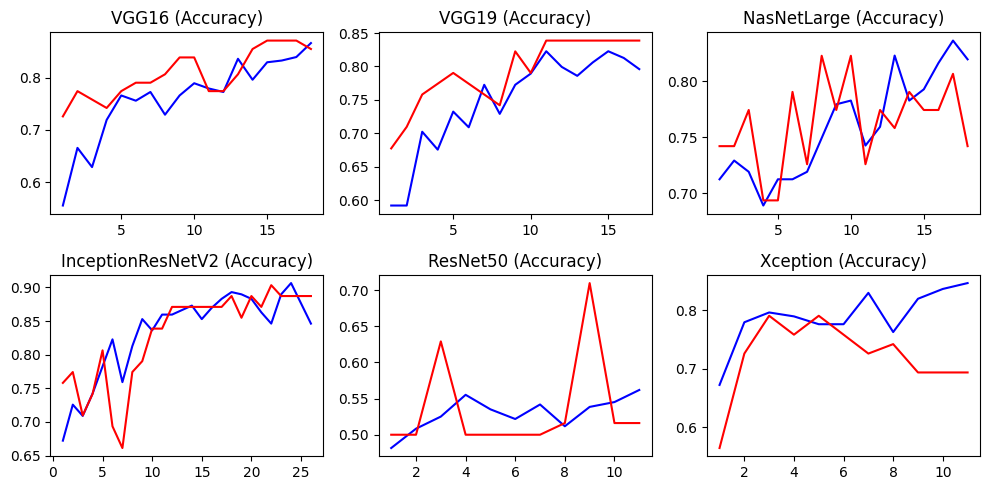

In [51]:
# Definimos el tamaño de cada figura.
plt.figure(figsize=(10,5))

# Para VGG16
plt.subplot(2, 3, 1)

epochs = range(1, len(VGG16_dg_acc) + 1)

plt.plot(epochs, VGG16_dg_acc, 'b', label='Training acc')
plt.plot(epochs,VGG16_dg_val_acc,'r', label='Validation acc')
plt.title('VGG16 (Accuracy)')

# Para VGG19
plt.subplot(2, 3, 2)

epochs = range(1, len(VGG19_dg_acc) + 1)

plt.plot(epochs, VGG19_dg_acc, 'b', label='Training acc')
plt.plot(epochs,VGG19_dg_val_acc,'r', label='Validation acc')
plt.title('VGG19 (Accuracy)')

# Para NasNetLarge
plt.subplot(2, 3, 3)

epochs = range(1, len(NasNetLarge_dg_acc) + 1)

plt.plot(epochs, NasNetLarge_dg_acc, 'b', label='Training acc')
plt.plot(epochs,NasNetLarge_dg_val_acc,'r', label='Validation acc')
plt.title('NasNetLarge (Accuracy)')

# Para InceptionResNetV2
plt.subplot(2, 3, 4)

epochs = range(1, len(InceptionResNetV2_dg_acc) + 1)

plt.plot(epochs, InceptionResNetV2_dg_acc, 'b', label='Training acc')
plt.plot(epochs,InceptionResNetV2_dg_val_acc,'r', label='Validation acc')
plt.title('InceptionResNetV2 (Accuracy)')

# Para ResNet50
plt.subplot(2, 3, 5)

epochs = range(1, len(ResNet50_dg_acc) + 1)

plt.plot(epochs, ResNet50_dg_acc, 'b', label='Training acc')
plt.plot(epochs,ResNet50_dg_val_acc,'r', label='Validation acc')
plt.title('ResNet50 (Accuracy)')

# Para Xception
plt.subplot(2, 3, 6)

epochs = range(1, len(Xception_dg_acc) + 1)

plt.plot(epochs, Xception_dg_acc, 'b', label='Training acc')
plt.plot(epochs,Xception_dg_val_acc,'r', label='Validation acc')
plt.title('Xception (Accuracy)')

plt.tight_layout()
plt.show()

#### Loss

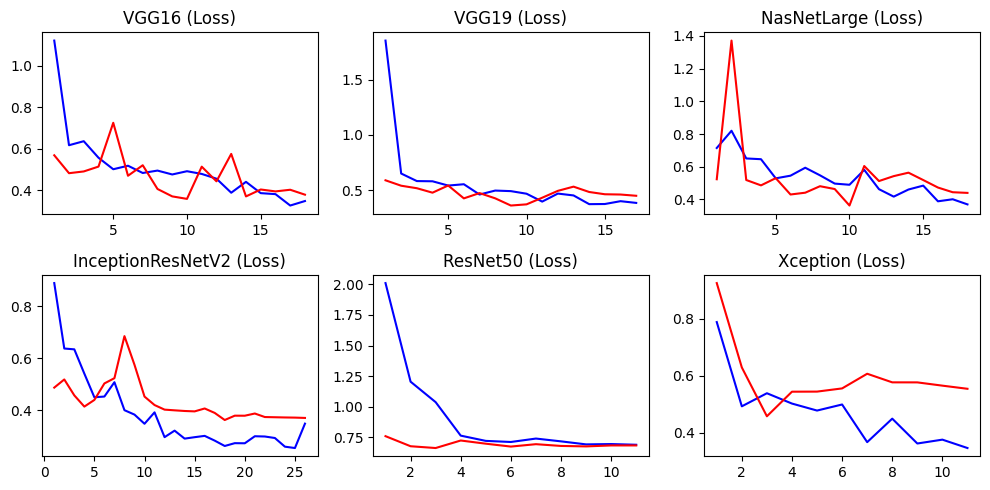

In [52]:
# Definimos el tamaño de cada figura.
plt.figure(figsize=(10,5))

# Para VGG16
plt.subplot(2, 3, 1)

epochs = range(1, len(VGG16_dg_loss) + 1)

plt.plot(epochs, VGG16_dg_loss, 'b', label='Training loss')
plt.plot(epochs,VGG16_dg_val_loss,'r', label='Validation loss')
plt.title('VGG16 (Loss)')

# Para VGG19
plt.subplot(2, 3, 2)

epochs = range(1, len(VGG19_dg_loss) + 1)

plt.plot(epochs, VGG19_dg_loss, 'b', label='Training loss')
plt.plot(epochs,VGG19_dg_val_loss,'r', label='Validation loss')
plt.title('VGG19 (Loss)')

# Para NasNetLarge
plt.subplot(2, 3, 3)

epochs = range(1, len(NasNetLarge_dg_loss) + 1)

plt.plot(epochs, NasNetLarge_dg_loss, 'b', label='Training loss')
plt.plot(epochs,NasNetLarge_dg_val_loss,'r', label='Validation loss')
plt.title('NasNetLarge (Loss)')

# Para InceptionResNetV2
plt.subplot(2, 3, 4)

epochs = range(1, len(InceptionResNetV2_dg_loss) + 1)

plt.plot(epochs, InceptionResNetV2_dg_loss, 'b', label='Training loss')
plt.plot(epochs,InceptionResNetV2_dg_val_loss,'r', label='Validation loss')
plt.title('InceptionResNetV2 (Loss)')

# Para ResNet50
plt.subplot(2, 3, 5)

epochs = range(1, len(ResNet50_dg_loss) + 1)

plt.plot(epochs, ResNet50_dg_loss, 'b', label='Training loss')
plt.plot(epochs,ResNet50_dg_val_loss,'r', label='Validation loss')
plt.title('ResNet50 (Loss)')

# Para Xception
plt.subplot(2, 3, 6)

epochs = range(1, len(Xception_dg_loss) + 1)

plt.plot(epochs, Xception_dg_loss, 'b', label='Training loss')
plt.plot(epochs,Xception_dg_val_loss,'r', label='Validation loss')
plt.title('Xception (Loss)')

plt.tight_layout()
plt.show()

### Evaluación del modelo

In [53]:
# Para VGG16
VGG16_dg_test_loss, VGG16_dg_test_acc = VGG16_dg.evaluate(test_generator)

# Para VGG19
VGG19_dg_test_loss, VGG19_dg_test_acc = VGG19_dg.evaluate(test_generator)

# Para NasNetLarge
NasNetLarge_dg_test_loss, NasNetLarge_dg_test_acc = NasNetLarge_dg.evaluate(test_generator)

# Para InceptionResNetV2
InceptionResNetV2_dg_test_loss, InceptionResNetV2_dg_test_acc = InceptionResNetV2_dg.evaluate(test_generator)

# Para ResNet50
ResNet50_dg_test_loss, ResNet50_dg_test_acc = ResNet50_dg.evaluate(test_generator)

# Para Xception
Xception_dg_test_loss, Xception_dg_test_acc = Xception_dg.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - acc: 0.8636 - loss: 0.3973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - acc: 0.7727 - loss: 0.4743
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - acc: 0.6364 - loss: 1.3034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - acc: 0.9545 - loss: 0.2796
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - acc: 0.5909 - loss: 0.6976
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - acc: 0.6364 - loss: 0.9057


In [54]:
# Vemos cual ha sido la precisión para cada caso.
print('Precisión para VGG16:', VGG16_dg_test_acc)
print('Precisión para VGG19:', VGG19_dg_test_acc)
print('Precisión para NasNetLarge:', NasNetLarge_dg_test_acc)
print('Precisión para InceptionResNetV2:', InceptionResNetV2_dg_test_acc)
print('Precisión para ResNet50:', ResNet50_dg_test_acc)
print('Precisión para Xception:', Xception_dg_test_acc)

Precisión para VGG16: 0.8636363744735718
Precisión para VGG19: 0.7727272510528564
Precisión para NasNetLarge: 0.6363636255264282
Precisión para InceptionResNetV2: 0.9545454382896423
Precisión para ResNet50: 0.5909090638160706
Precisión para Xception: 0.6363636255264282


In [55]:
# Look at confusion matrix
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ["Defective", "Non-Defective"])
    plt.yticks(tick_marks, ["Defective", "Non-Defective"], rotation=45)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.mean()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [56]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

#### VGG16

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Text(0.5, 1.0, 'Confusion matrix (VGG16)')

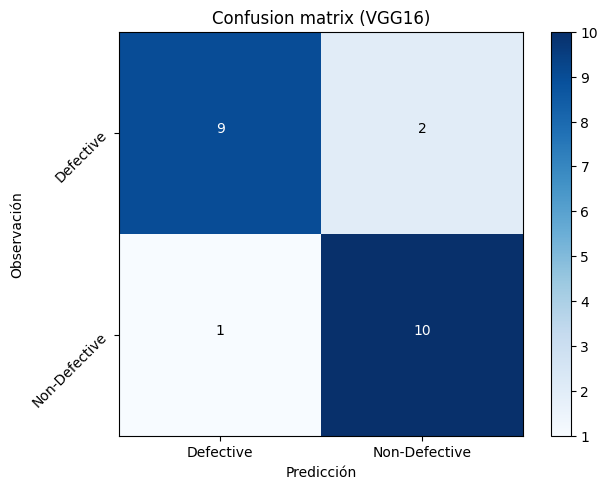

In [57]:
# Predict the values from the validation dataset
Y_pred = VGG16_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('Confusion matrix (VGG16)')

#### VGG19

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


Text(0.5, 1.0, 'Confusion matrix (VGG19)')

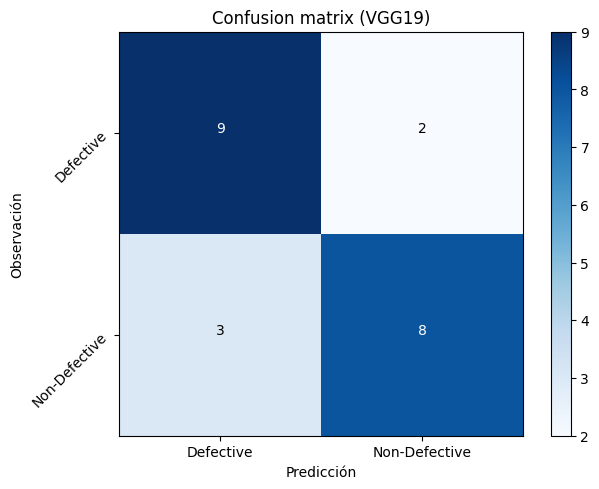

In [58]:
# Predict the values from the validation dataset
Y_pred = VGG19_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('Confusion matrix (VGG19)')

#### NasNetLarge

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


Text(0.5, 1.0, 'Confusion matrix (NasNetLarge)')

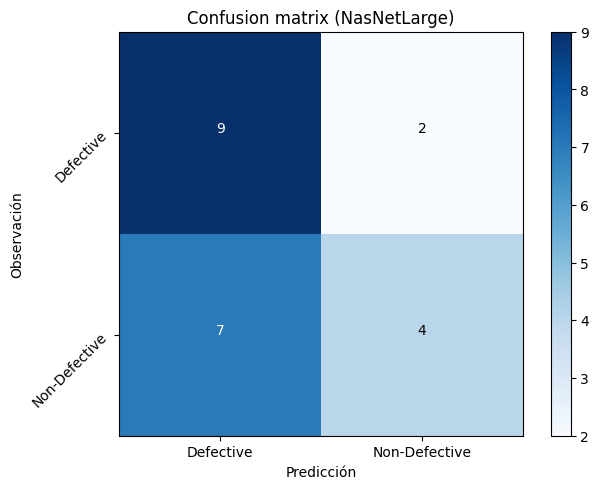

In [59]:
# Predict the values from the validation dataset
Y_pred = NasNetLarge_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('Confusion matrix (NasNetLarge)')

#### InceptionResNetV2

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Text(0.5, 1.0, 'Confusion matrix (InceptionResNetV2)')

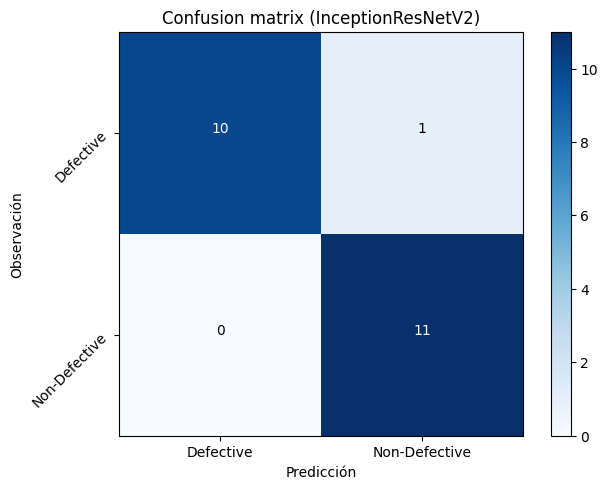

In [60]:
# Predict the values from the validation dataset
Y_pred = InceptionResNetV2_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('Confusion matrix (InceptionResNetV2)')

#### ResNet50

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Text(0.5, 1.0, 'Confusion matrix (ResNet50)')

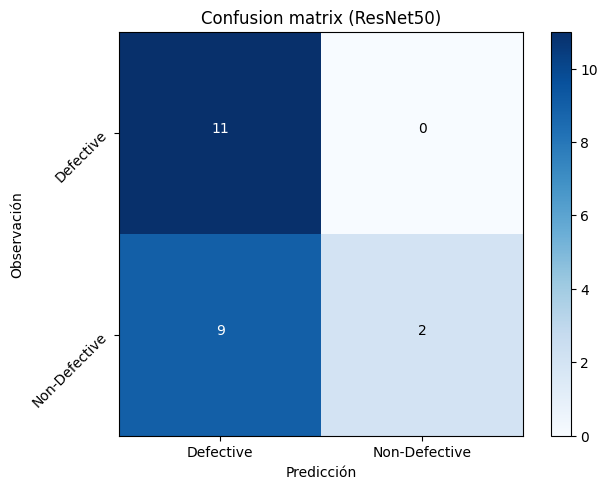

In [61]:
# Predict the values from the validation dataset
Y_pred = ResNet50_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('Confusion matrix (ResNet50)')

#### Xception

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Text(0.5, 1.0, 'Confusion matrix (Xception)')

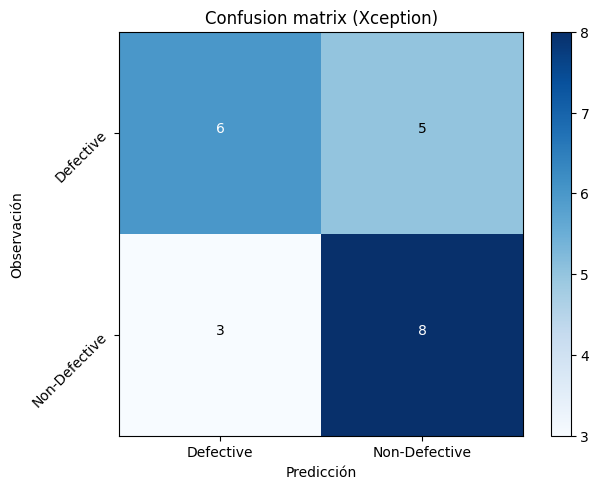

In [62]:
# Predict the values from the validation dataset
Y_pred = Xception_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('Confusion matrix (Xception)')

#### Conjunto completo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


Text(0.5, 1.0, 'Xception')

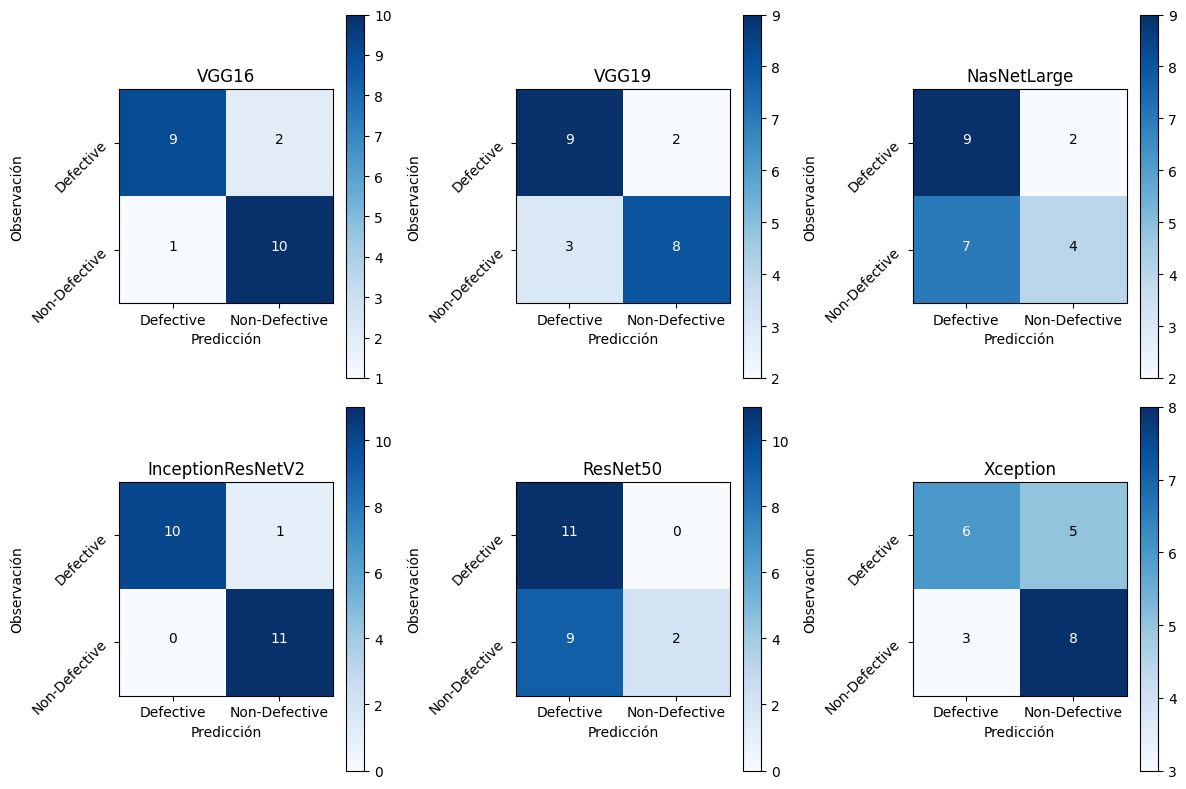

In [63]:
# Definimos el tamaño de las imagenes
plt.figure(figsize=(12,8))

# Para VGG16

# Predict the values from the validation dataset
Y_pred = VGG16_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plt.subplot(2, 3, 1)
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('VGG16')

# Para VGG19

# Predict the values from the validation dataset
Y_pred = VGG19_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plt.subplot(2, 3, 2)
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('VGG19')

# Para NasNetLarge

# Predict the values from the validation dataset
Y_pred = NasNetLarge_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plt.subplot(2, 3, 3)
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('NasNetLarge')

# Para InceptionResNetV2

# Predict the values from the validation dataset
Y_pred = InceptionResNetV2_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plt.subplot(2, 3, 4)
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('InceptionResNetV2')

# Para ResNet50

# Predict the values from the validation dataset
Y_pred = ResNet50_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plt.subplot(2, 3, 5)
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('ResNet50')

#Para Xception

# Predict the values from the validation dataset
Y_pred = Xception_dg.predict(test_generator)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_generator.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plt.subplot(2, 3, 6)
plot_confusion_matrix(confusion_mtx, classes = range(2))
plt.title('Xception')